<a href="https://colab.research.google.com/github/RezuanChowdhuryRifat/Bad-root-canal-detection/blob/rezuan/SimCLR_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [ ]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.12.1+cu113
DEVICE: cuda


In [ ]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [ ]:
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.makedirs("dataset/data")
!cp "/content/drive/MyDrive/dataset/Radiographic dataset/Radiographs.zip" dataset/data.zip
!unzip dataset/data.zip -d dataset/data


Archive:  dataset/data.zip
  inflating: dataset/data/Radiographs/1.JPG  
  inflating: dataset/data/Radiographs/100.JPG  
  inflating: dataset/data/Radiographs/1000.JPG  
  inflating: dataset/data/Radiographs/1001.JPG  
  inflating: dataset/data/Radiographs/1002.JPG  
  inflating: dataset/data/Radiographs/1004.JPG  
  inflating: dataset/data/Radiographs/1007.JPG  
  inflating: dataset/data/Radiographs/1008.JPG  
  inflating: dataset/data/Radiographs/1009.JPG  
  inflating: dataset/data/Radiographs/101.JPG  
  inflating: dataset/data/Radiographs/1010.JPG  
  inflating: dataset/data/Radiographs/1011.JPG  
  inflating: dataset/data/Radiographs/1012.JPG  
  inflating: dataset/data/Radiographs/1013.JPG  
  inflating: dataset/data/Radiographs/1014.JPG  
  inflating: dataset/data/Radiographs/1015.JPG  
  inflating: dataset/data/Radiographs/1016.JPG  
  inflating: dataset/data/Radiographs/1017.JPG  
  inflating: dataset/data/Radiographs/1018.JPG  
  inflating: dataset/data/Radiographs/102.JPG  

In [ ]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

flowers_ds = CustomDataset(
    list_images=glob.glob("/content/dataset/data/Radiographs/*.jpg"),
    transform=custom_transform
)

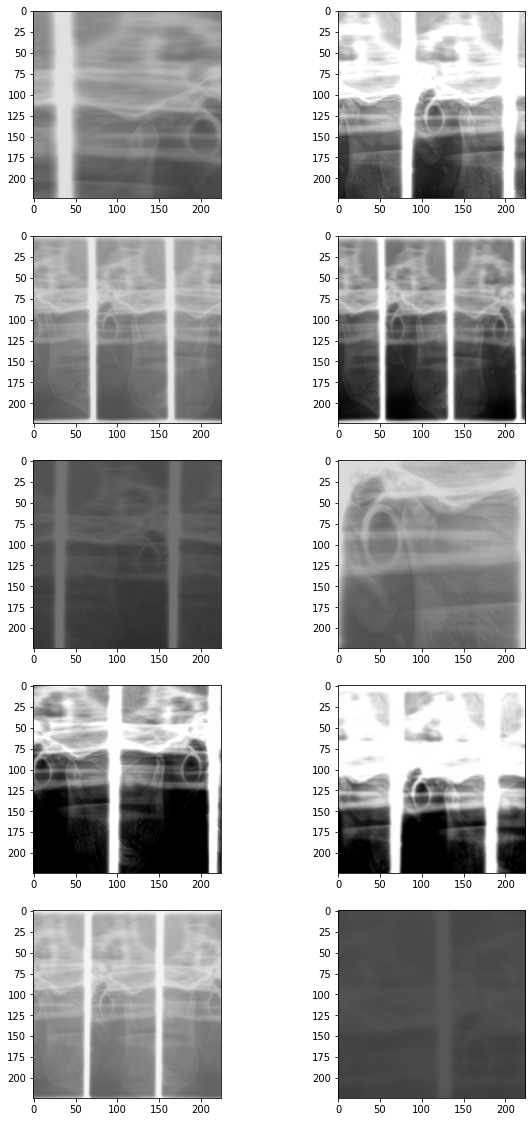

In [ ]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(flowers_ds,200)

In [ ]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [ ]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [ ]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
EPOCHS = 100
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 1 LOSS: 0.1062 
Time taken: 0.717 mins
EPOCH: 2 BATCH: 1 LOSS: 0.0578 
Time taken: 0.663 mins
EPOCH: 3 BATCH: 1 LOSS: 0.0561 
Time taken: 0.681 mins
EPOCH: 4 BATCH: 1 LOSS: 0.0554 
Time taken: 0.690 mins
EPOCH: 5 BATCH: 1 LOSS: 0.0556 
Time taken: 0.666 mins
EPOCH: 6 BATCH: 1 LOSS: 0.0552 
Time taken: 0.688 mins
EPOCH: 7 BATCH: 1 LOSS: 0.0554 
Time taken: 0.687 mins
EPOCH: 8 BATCH: 1 LOSS: 0.0558 
Time taken: 0.634 mins
EPOCH: 9 BATCH: 1 LOSS: 0.0552 
Time taken: 0.664 mins
EPOCH: 10 BATCH: 1 LOSS: 0.0553 
Time taken: 0.725 mins
EPOCH: 11 BATCH: 1 LOSS: 0.0553 
Time taken: 0.701 mins
EPOCH: 12 BATCH: 1 LOSS: 0.0552 
Time taken: 0.697 mins
EPOCH: 13 BATCH: 1 LOSS: 0.0552 
Time taken: 0.818 mins
EPOCH: 14 BATCH: 1 LOSS: 0.0552 
Time taken: 0.673 mins
EPOCH: 15 BATCH: 1 LOSS: 0.0553 
Time taken: 0.720 mins
EPOCH: 16 BATCH: 1 LOSS: 0.0554 
Time taken: 0.731 mins
EPOCH: 17 BATCH: 1 LOSS: 0.0551 
Time taken: 0.680 mins
EPOCH: 18 BATCH: 1 LOSS: 0.0552 
Time taken: 0.703 mins
E

In [ ]:
print("Model's state_dict:")
for param_tensor in simclr_model.state_dict():
    print(param_tensor, "\t", simclr_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Streaming output truncated to the last 5000 lines.
        2.5148e-07, 1.3253e-07, 1.7188e-07, 1.4576e-07, 4.2322e-07, 3.6471e-07,
        1.5653e-07, 2.2799e-07, 3.5880e-07, 1.4962e-07, 1.6547e-07, 3.4229e-07,
        1.5429e-07, 2.0864e-07, 3.1227e-07, 1.8977e-08, 6.9863e-07, 3.2922e-08,
        1.5863e-07, 5.2984e-08, 2.5848e-07, 2.8049e-07, 1.6653e-07, 1.4910e-07,
        7.0708e-07, 5.1458e-08, 8.3140e-08, 1.6921e-07, 1.1766e-07, 4.0995e-07,
        2.5415e-07, 1.2596e-07, 3.7313e-07, 2.7489e-07, 5.8685e-08, 1.4873e-07,
        2.0134e-07, 1.4180e-07, 2.3120e-07, 4.3506e-07, 4.5053e-07, 3.5275e-07,
        1.3183e-07, 3.0571e-07, 8.7676e-08, 7.3403e-07, 1.1605e-06, 7.2967e-08,
        1.8886e-07, 4.1651e-07, 1.3969e-07, 9.6758e-08, 1.2895e-07, 1.9949e-07,
        1.0394e-06, 3.1707e-07, 6.3090e-07, 4.2219e-07, 1.0424e-07, 1.1826e-07,
        1.3357e-07, 2.0408e-07, 1.9802e-07, 3.4391e-07, 9.4439e-08, 1.7791e-07,
        4.3031e-08, 2.2220e-07, 2.9650e-07, 2.9357e-07, 2.4246e-07, 2

In [ ]:
PATH = "/content/drive/MyDrive/dataset/Radiographic dataset/encoder.pth"
torch.save(simclr_model.state_dict(), PATH)

In [ ]:
model = SimCLR()
model.load_state_dict(torch.load(PATH))
# model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
print(model)

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn